# Color correction análysis

In [130]:
from exp import *

In [131]:
dm = DatasetManager('2017','train_images',224,'all','2017')

In [132]:
# dm.generate_dataset()

In [133]:
len(dm.get_dataset_path().ls())

2001

In [134]:
def reload_dataset(dm,seed=1):
    random_seed(seed,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.1, max_lighting=.2,p_affine=1, max_warp=0)

    data = ImageList.from_folder(dm.get_dataset_path())\
    .split_by_rand_pct()\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms,size=128)\
    .databunch(bs=16)\
    .normalize(imagenet_stats)
    return data

data = reload_dataset(dm)

In [ ]:
sorted(data.train_ds.tfms, key=lambda x: x.order)

In [ ]:
data.show_batch(3)

In [ ]:
def _plot(i,j,ax,img_index=0):
    x,y = data.train_ds[img_index]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [ ]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

# Lets test a baseline

In [63]:
random_seed(1,True)
learn = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph], 
                        pretrained=True)

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.993076,0.662477,0.247500,0.752500,0.698583,00:04
1,0.503908,0.405077,0.162500,0.837500,0.796460,00:04
2,0.352536,0.334280,0.132500,0.867500,0.848784,00:04
3,0.307977,0.325259,0.115000,0.885000,0.854248,00:04


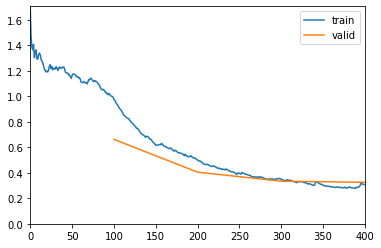

In [64]:
random_seed(1,True)
learn.fit_one_cycle(4)

In [65]:
learn.unfreeze()

In [67]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 5.75E-07


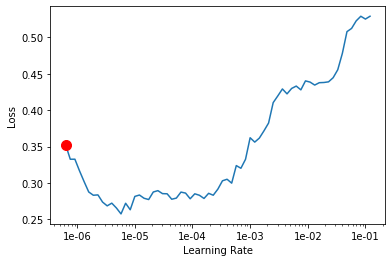

In [68]:
learn.recorder.plot(suggestion=True)

In [66]:
learn.save('color_analysis_head_trained')

In [ ]:
learn.load('color_analysis_head_trained')

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.092553,0.324041,0.107500,0.892500,0.853475,00:06
1,0.053213,0.317834,0.110000,0.890000,0.853378,00:06
2,0.035850,0.310615,0.107500,0.892500,0.865806,00:06
3,0.204631,0.325016,0.115000,0.885000,0.854780,00:06
4,0.293730,0.315733,0.115000,0.885000,0.863291,00:06
5,0.270176,0.301857,0.112500,0.887500,0.865758,00:06
6,0.253588,0.311418,0.110000,0.890000,0.861212,00:06
7,0.264030,0.308773,0.110000,0.890000,0.864500,00:06
8,0.255551,0.307943,0.110000,0.890000,0.864694,00:06
9,0.275091,0.307164,0.112500,0.887500,0.865758,00:06


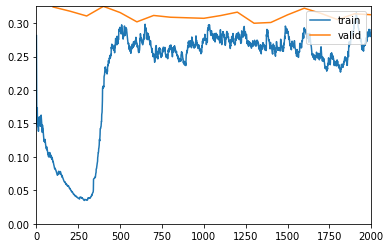

In [69]:
random_seed(1,True)
learn.fit_one_cycle(20,max_lr=slice(1.10E-06))

# Color correction

## Max RGB

In [135]:
def max_rgb(image):
  # First get the maximum across the rows, then take the values and take the maximum again (this time dimension 1 will be the columns)
    e = image.max(dim=1)[0].max(dim=1)[0]
    k = 1 / torch.norm(e)
    return e * k
  
def computeGrayWorldOnChannel(image, channel,p):
    I_cx = image[channel].sum()
    img_size = image[channel].shape.numel()
    return ( (I_cx ** p) / img_size )  ** (1/p) 

def shades_of_gray(img, p):
    n_channels, height, width  = img.shape
    iluminant = torch.zeros(3)
    for channel in range(n_channels):
        iluminant[channel] = computeGrayWorldOnChannel(img,channel,p)
    return iluminant

In [136]:
def correct_iluminant(estimated_iluminant):
    gamma = (torch.ones(3) / math.sqrt(3))
    corrected_iluminant = gamma * (1 / estimated_iluminant)
    return corrected_iluminant

def correct_image(image,estimated_iluminant):
    corrected_iluminant = correct_iluminant(estimated_iluminant)
    mat_iluminant = corrected_iluminant[:,None,None].expand(image.shape)
    c = mat_iluminant * image
    return c

In [137]:
def _correct_color_max_rgb(image):
    estimated_iluminant = max_rgb(image);
    c = correct_image(image,estimated_iluminant)
    return c

def _correct_color_shades_of_gray(image):
    estimated_iluminant = shades_of_gray(image,1);
    print(estimated_iluminant)
    c = correct_image(image,estimated_iluminant)
    return torch.clamp(c,0,1)

correct_color_max_rgb = TfmPixel(_correct_color_max_rgb)
correct_color_shades_of_gray = TfmPixel(_correct_color_shades_of_gray)

## Show color correction changes

In [138]:
data = reload_dataset(dm.get_dataset_path())

AttributeError: 'PosixPath' object has no attribute 'get_dataset_path'

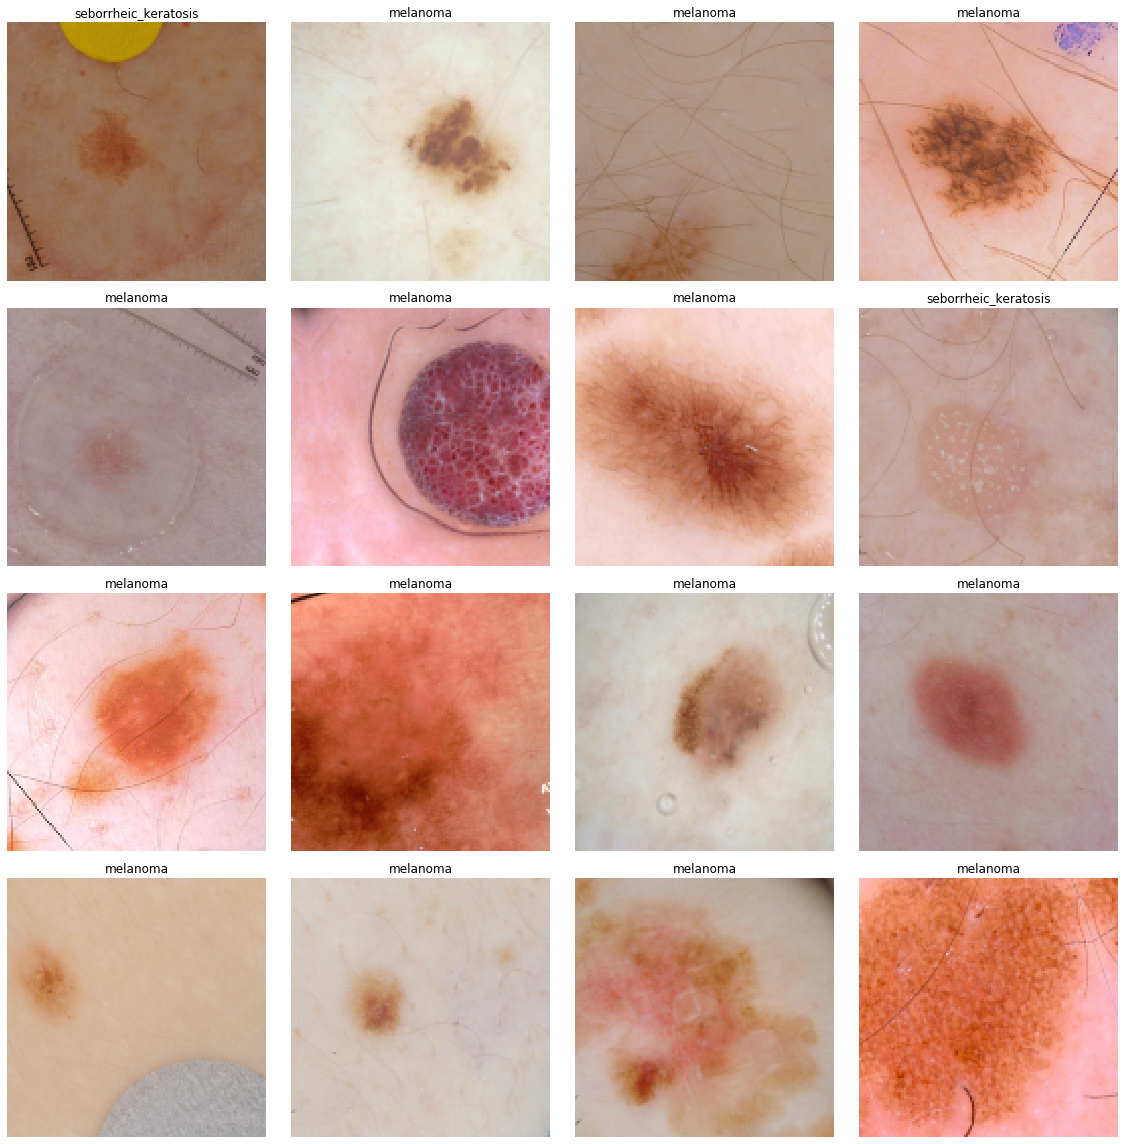

In [139]:
random_seed(1,True)
data.show_batch()

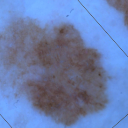

In [140]:
data.train_ds[1][0]

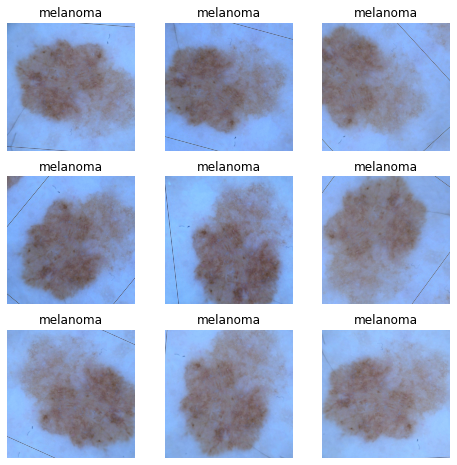

In [141]:
plot_multi(partial(_plot,img_index=1), 3, 3, figsize=(8,8))

In [143]:
correct_color_max_rgb.order = 0 
data.train_ds.tfms.insert(0,correct_color_max_rgb());
data.valid_ds.tfms.insert(0,correct_color_max_rgb());

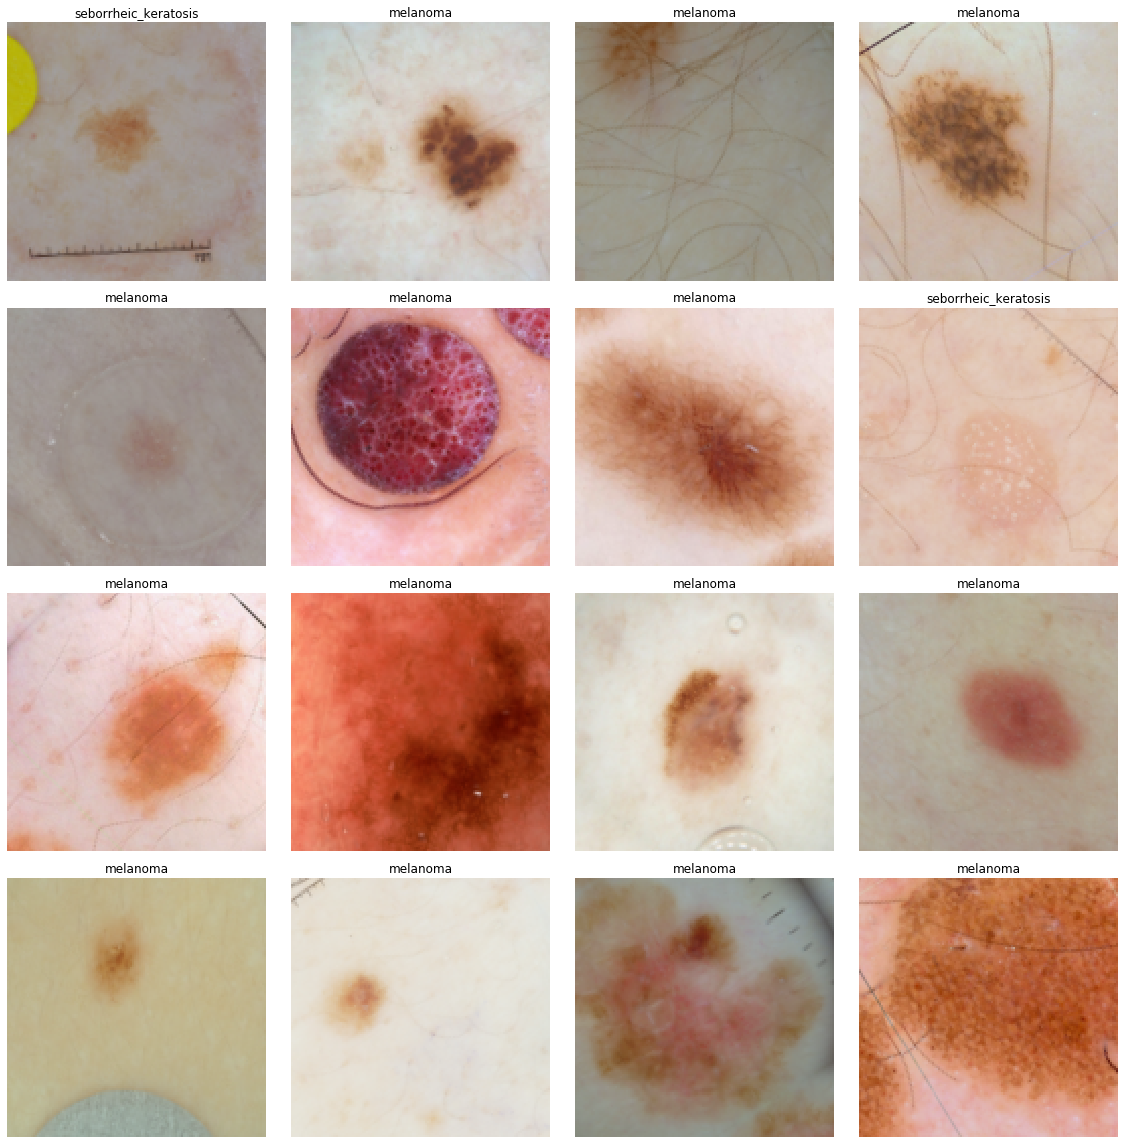

In [144]:
random_seed(1,True)
data.show_batch()

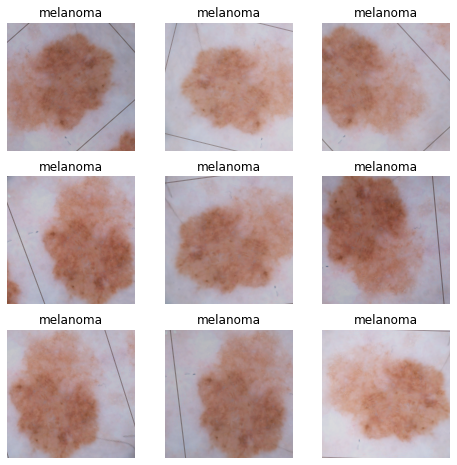

In [145]:
data.train_ds.tfms.insert(0,correct_color_max_rgb());
data.valid_ds.tfms.insert(0,correct_color_max_rgb());

plot_multi(partial(_plot,img_index=1), 3, 3, figsize=(8,8))

## Train color correction

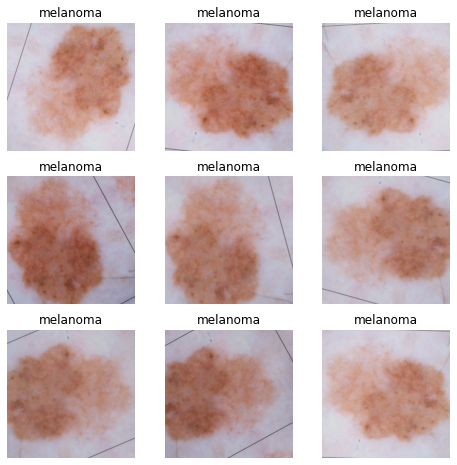

In [147]:
data = reload_dataset(dm)
correct_color_max_rgb.order = 0 
data.train_ds.tfms.insert(0,correct_color_max_rgb());
data.valid_ds.tfms.insert(0,correct_color_max_rgb());

plot_multi(partial(_plot,img_index=1), 3, 3, figsize=(8,8))

In [148]:
random_seed(1,True)
learn = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph], 
                        pretrained=True)

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.057096,0.639268,0.230000,0.770000,0.760192,00:04
1,0.511612,0.415332,0.142500,0.857500,0.785676,00:04
2,0.375300,0.346292,0.132500,0.867500,0.842255,00:04
3,0.300999,0.297276,0.127500,0.872500,0.882538,00:04


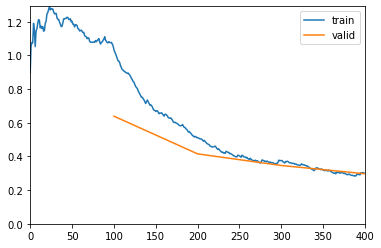

In [149]:
random_seed(1,True)
learn.fit_one_cycle(4)

In [150]:
learn.unfreeze()

In [151]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.29E-05


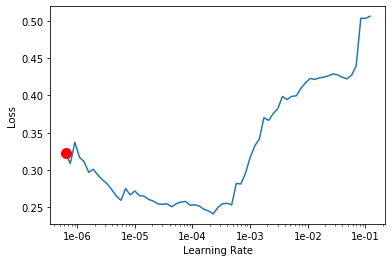

In [152]:
learn.recorder.plot(suggestion=True)

In [153]:
learn.save('color_analysis_head_trained')

In [154]:
learn.load('color_analysis_head_trained')

Learner(data=ImageDataBunch;

Train: LabelList (1600 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
melanoma,melanoma,melanoma,melanoma,melanoma
Path: 2017_train_images_resized_to_224_picked_all_training_for_2017;

Valid: LabelList (400 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
melanoma,melanoma,melanoma,melanoma,melanoma
Path: 2017_train_images_resized_to_224_picked_all_training_for_2017;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.114790,0.301252,0.132500,0.867500,0.884859,00:06
1,0.058064,0.294984,0.130000,0.870000,0.885729,00:06
2,0.040477,0.300656,0.132500,0.867500,0.882006,00:06
3,0.191398,0.296055,0.127500,0.872500,0.885294,00:06
4,0.256595,0.287026,0.142500,0.857500,0.892742,00:06
5,0.247181,0.282482,0.137500,0.862500,0.896610,00:06
6,0.236844,0.279283,0.122500,0.877500,0.896900,00:06
7,0.250898,0.276327,0.130000,0.870000,0.900334,00:06
8,0.216559,0.276675,0.132500,0.867500,0.903332,00:06


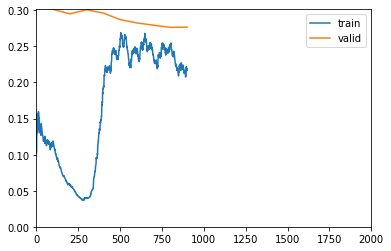

In [ ]:
random_seed(1,True)
learn.fit_one_cycle(20,max_lr=slice(2.29E-05))

# Comparison for various seeds

In [126]:
def simple_train(learner,seed, epochs):
    random_seed(seed,True)
    learner.fit_one_cycle(4)

    learner.unfreeze()

    random_seed(seed,True)
    learner.fit_one_cycle(epochs,max_lr=slice(1.10E-06))

In [127]:

columns = ['Without Color Correction','With Max RGB']
', '.join(columns) + '\n'

'Without Color Correction, With Max RGB\n'

In [128]:
results_file_name = 'color_analysis_run_seed'
columns = ['Without Color Correction','With Max RGB']
def write_results(seed,first_learner,second_learner):
    l1 = list(map(lambda x: x[1], first_learner.recorder.metrics))
    l2 = list(map(lambda x: x[1], second_learner.recorder.metrics))

    f = open(f'{results_file_name}_{s}.txt','w+')
    f.write(', '.join(columns) + '\n')
    run = ''.join(map(str,[f'{a.item()},{b.item()}\n' for a,b in zip(l1,l2) ]))
    f.write(run)
    f.close()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.993076,0.662477,0.247500,0.752500,0.698583,00:04
1,0.503908,0.405077,0.162500,0.837500,0.796460,00:04
2,0.352536,0.334280,0.132500,0.867500,0.848784,00:04
3,0.307977,0.325259,0.115000,0.885000,0.854248,00:04


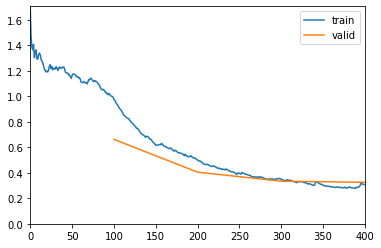

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.092553,0.324041,0.107500,0.892500,0.853475,00:06
1,0.053213,0.317834,0.110000,0.890000,0.853378,00:06
2,0.035850,0.310615,0.107500,0.892500,0.865806,00:06
3,0.204631,0.325016,0.115000,0.885000,0.854780,00:06
4,0.293730,0.315733,0.115000,0.885000,0.863291,00:06
5,0.270176,0.301857,0.112500,0.887500,0.865758,00:06
6,0.253588,0.311418,0.110000,0.890000,0.861212,00:06
7,0.264030,0.308773,0.110000,0.890000,0.864500,00:06
8,0.255551,0.307943,0.110000,0.890000,0.864694,00:06
9,0.275091,0.307164,0.112500,0.887500,0.865758,00:06


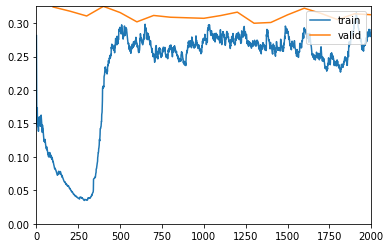

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.032737,0.786339,0.280000,0.720000,0.677983,00:04
1,0.517881,0.429994,0.170000,0.830000,0.802940,00:04
2,0.369715,0.353964,0.147500,0.852500,0.856376,00:04
3,0.310874,0.343749,0.140000,0.860000,0.860051,00:04


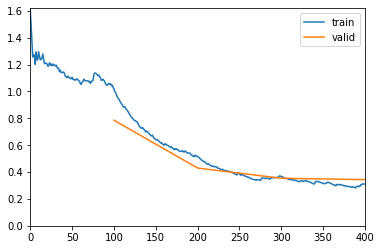

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.103010,0.344692,0.157500,0.842500,0.860341,00:06
1,0.060153,0.335780,0.160000,0.840000,0.865032,00:06
2,0.038991,0.339870,0.147500,0.852500,0.862372,00:06
3,0.202190,0.343758,0.140000,0.860000,0.859616,00:06
4,0.289693,0.341678,0.147500,0.852500,0.858504,00:06
5,0.280087,0.340390,0.157500,0.842500,0.860487,00:06
6,0.259799,0.337477,0.147500,0.852500,0.856666,00:06
7,0.262351,0.345371,0.157500,0.842500,0.857343,00:06
8,0.289304,0.340165,0.150000,0.850000,0.860100,00:06
9,0.270004,0.328845,0.150000,0.850000,0.865903,00:06


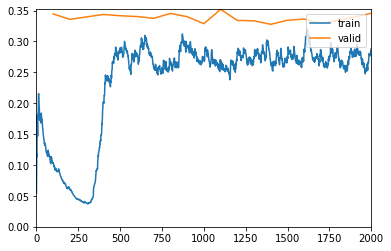

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.892889,0.570264,0.220000,0.780000,0.735026,00:04
1,0.517143,0.294849,0.117500,0.882500,0.851267,00:04
2,0.362430,0.266587,0.105000,0.895000,0.867898,00:04
3,0.294824,0.258673,0.102500,0.897500,0.873580,00:04


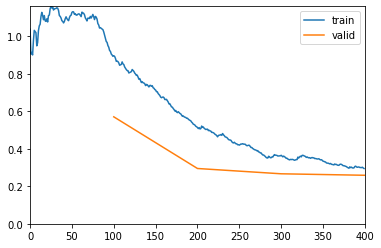

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.106399,0.250037,0.097500,0.902500,0.881274,00:06
1,0.052910,0.252330,0.095000,0.905000,0.875533,00:06
2,0.040099,0.253769,0.095000,0.905000,0.879202,00:06
3,0.187469,0.258246,0.102500,0.897500,0.873816,00:06
4,0.252982,0.247785,0.095000,0.905000,0.883286,00:06
5,0.283920,0.250354,0.090000,0.910000,0.885239,00:06
6,0.260839,0.256659,0.100000,0.900000,0.873343,00:06
7,0.277699,0.251934,0.095000,0.905000,0.877722,00:06
8,0.285419,0.257915,0.102500,0.897500,0.876065,00:06
9,0.263752,0.251223,0.095000,0.905000,0.879853,00:06


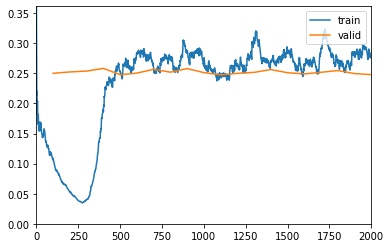

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.965916,0.410959,0.155000,0.845000,0.812678,00:04
1,0.500530,0.319341,0.117500,0.882500,0.823686,00:04
2,0.356578,0.291643,0.115000,0.885000,0.826705,00:04
3,0.295419,0.270919,0.105000,0.895000,0.853279,00:04


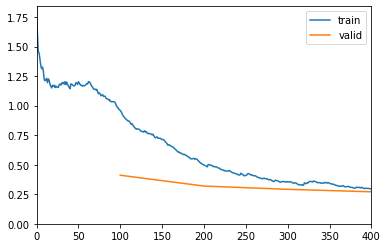

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.089700,0.268618,0.102500,0.897500,0.856357,00:06
1,0.049249,0.271183,0.102500,0.897500,0.853930,00:06
2,0.036870,0.269791,0.105000,0.895000,0.854640,00:06
3,0.184530,0.270915,0.102500,0.897500,0.852805,00:06
4,0.274377,0.277197,0.102500,0.897500,0.853042,00:06
5,0.286059,0.275623,0.100000,0.900000,0.853575,00:06
6,0.280052,0.265334,0.097500,0.902500,0.865589,00:06
7,0.280254,0.263081,0.100000,0.900000,0.863222,00:06
8,0.271939,0.269921,0.102500,0.897500,0.854226,00:06
9,0.270580,0.269072,0.097500,0.902500,0.863281,00:06


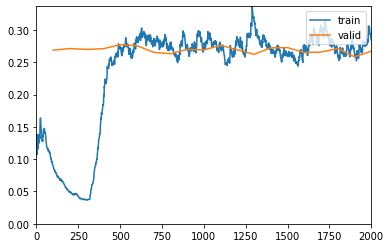

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.992088,0.602143,0.255000,0.745000,0.726205,00:04
1,0.523598,0.435832,0.152500,0.847500,0.797721,00:04
2,0.349904,0.304040,0.120000,0.880000,0.852724,00:04
3,0.284169,0.281029,0.125000,0.875000,0.862492,00:04


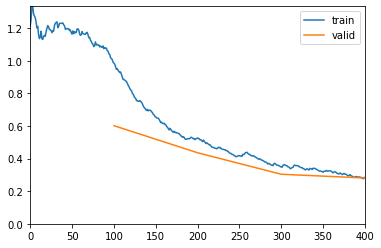

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.088411,0.276147,0.117500,0.882500,0.857085,00:06
1,0.051346,0.280729,0.117500,0.882500,0.858771,00:06
2,0.034612,0.278508,0.120000,0.880000,0.867085,00:06
3,0.176363,0.280689,0.125000,0.875000,0.863073,00:06
4,0.276443,0.276880,0.115000,0.885000,0.863946,00:06
5,0.272899,0.283251,0.125000,0.875000,0.864760,00:06
6,0.259793,0.284781,0.120000,0.880000,0.860748,00:06
7,0.273870,0.285431,0.120000,0.880000,0.866097,00:06
8,0.257962,0.286386,0.122500,0.877500,0.862143,00:06
9,0.266586,0.277117,0.122500,0.877500,0.867376,00:06


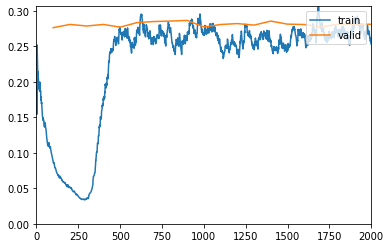

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.972989,0.644637,0.240000,0.760000,0.710797,00:04
1,0.511066,0.433432,0.150000,0.850000,0.817141,00:04
2,0.364982,0.283109,0.105000,0.895000,0.841386,00:04
3,0.280279,0.276693,0.100000,0.900000,0.855166,00:04


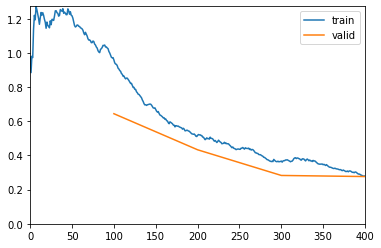

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.095223,0.280886,0.102500,0.897500,0.850922,00:06
1,0.062720,0.281751,0.100000,0.900000,0.849119,00:06
2,0.039301,0.273746,0.102500,0.897500,0.853073,00:06
3,0.168381,0.275914,0.097500,0.902500,0.855689,00:06
4,0.280090,0.274538,0.097500,0.902500,0.859469,00:06
5,0.281050,0.271139,0.095000,0.905000,0.864411,00:06
6,0.274891,0.272067,0.102500,0.897500,0.865574,00:06
7,0.278929,0.280001,0.100000,0.900000,0.854061,00:06
8,0.280315,0.270858,0.097500,0.902500,0.864585,00:06
9,0.276132,0.273838,0.100000,0.900000,0.859876,00:06


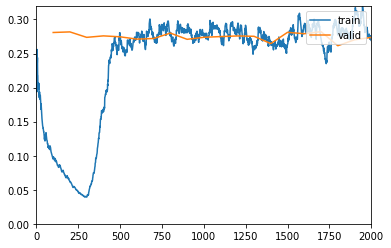

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.008492,0.852924,0.297500,0.702500,0.691221,00:04
1,0.492023,0.447873,0.140000,0.860000,0.796775,00:04
2,0.341521,0.387008,0.142500,0.857500,0.840007,00:04
3,0.287442,0.349445,0.137500,0.862500,0.858611,00:04


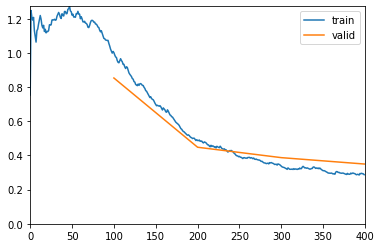

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.093978,0.378203,0.135000,0.865000,0.859408,00:06
1,0.053696,0.354341,0.132500,0.867500,0.854979,00:06
2,0.034844,0.369359,0.137500,0.862500,0.854536,00:06
3,0.184405,0.348977,0.137500,0.862500,0.859054,00:06
4,0.250271,0.366671,0.142500,0.857500,0.864856,00:06
5,0.292513,0.360354,0.132500,0.867500,0.861977,00:06
6,0.270847,0.348028,0.132500,0.867500,0.865432,00:06
7,0.260905,0.354532,0.132500,0.867500,0.862464,00:06
8,0.261704,0.334226,0.130000,0.870000,0.872121,00:06
9,0.252245,0.362089,0.135000,0.865000,0.858434,00:06


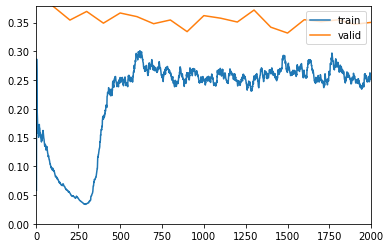

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.000710,0.733336,0.267500,0.732500,0.640459,00:04
1,0.510890,0.443083,0.155000,0.845000,0.781449,00:04
2,0.340704,0.355041,0.150000,0.850000,0.854093,00:04
3,0.290721,0.321926,0.140000,0.860000,0.877569,00:04


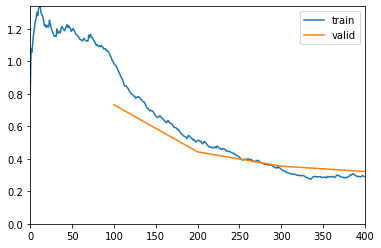

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.104002,0.341318,0.140000,0.860000,0.868001,00:06
1,0.058009,0.327275,0.137500,0.862500,0.875576,00:06
2,0.034345,0.322729,0.140000,0.860000,0.876860,00:06
3,0.191848,0.321976,0.140000,0.860000,0.877879,00:06
4,0.242518,0.340476,0.137500,0.862500,0.878676,00:06
5,0.297603,0.324676,0.140000,0.860000,0.879119,00:06
6,0.260433,0.316634,0.132500,0.867500,0.879651,00:06
7,0.261425,0.325320,0.145000,0.855000,0.877569,00:06
8,0.286280,0.334766,0.147500,0.852500,0.869153,00:06
9,0.264150,0.327342,0.142500,0.857500,0.882087,00:06


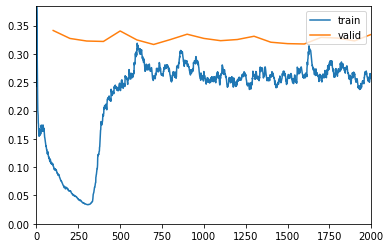

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.952367,0.517671,0.197500,0.802500,0.745978,00:04
1,0.519001,0.347838,0.127500,0.872500,0.811831,00:04
2,0.348872,0.311435,0.120000,0.880000,0.841565,00:04
3,0.279043,0.266461,0.100000,0.900000,0.859531,00:04


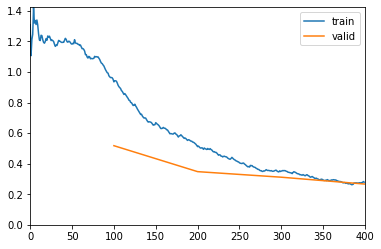

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.084764,0.261712,0.095000,0.905000,0.861909,00:06
1,0.048128,0.262482,0.102500,0.897500,0.863912,00:06
2,0.033221,0.261943,0.110000,0.890000,0.869358,00:06
3,0.179287,0.266528,0.102500,0.897500,0.859092,00:06
4,0.271197,0.264007,0.100000,0.900000,0.863161,00:06
5,0.256036,0.266469,0.097500,0.902500,0.861659,00:06
6,0.279527,0.263641,0.097500,0.902500,0.866041,00:06
7,0.244156,0.266813,0.107500,0.892500,0.856901,00:06
8,0.266779,0.263898,0.100000,0.900000,0.863161,00:06
9,0.263485,0.264609,0.112500,0.887500,0.872426,00:06


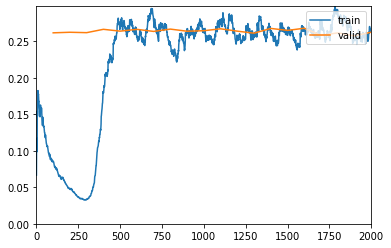

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.931316,0.600936,0.230000,0.770000,0.710423,00:04
1,0.486395,0.298785,0.115000,0.885000,0.843881,00:04
2,0.359338,0.281977,0.102500,0.897500,0.844820,00:04
3,0.291792,0.270442,0.090000,0.910000,0.850204,00:04


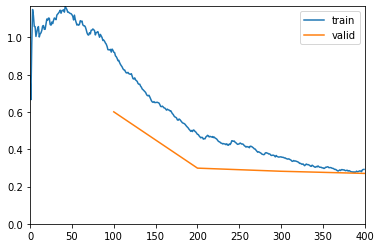

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.109538,0.256696,0.090000,0.910000,0.859781,00:06
1,0.062233,0.258801,0.085000,0.915000,0.864601,00:06
2,0.036252,0.258976,0.090000,0.910000,0.864726,00:06
3,0.191552,0.269614,0.090000,0.910000,0.850391,00:06
4,0.239492,0.263924,0.085000,0.915000,0.857840,00:06
5,0.258875,0.266415,0.087500,0.912500,0.854272,00:06
6,0.273572,0.261598,0.087500,0.912500,0.857903,00:06
7,0.265051,0.263842,0.085000,0.915000,0.859405,00:06
8,0.275647,0.265634,0.090000,0.910000,0.858091,00:06
9,0.263330,0.270509,0.105000,0.895000,0.861095,00:06


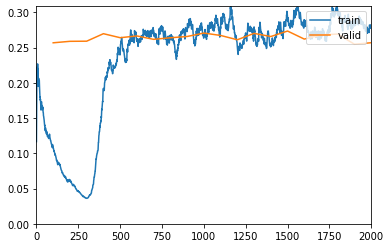

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.017493,0.556692,0.187500,0.812500,0.815600,00:04
1,0.530723,0.281516,0.100000,0.900000,0.854343,00:04
2,0.401940,0.268348,0.087500,0.912500,0.854914,00:04
3,0.322548,0.244362,0.087500,0.912500,0.884057,00:04


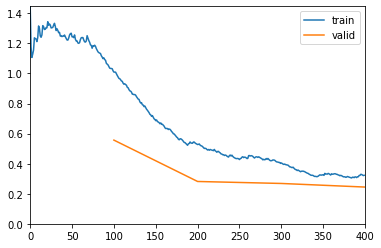

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.107257,0.256945,0.085000,0.915000,0.876229,00:06
1,0.056887,0.251183,0.082500,0.917500,0.877371,00:06
2,0.047581,0.252242,0.087500,0.912500,0.877886,00:06
3,0.220215,0.243871,0.087500,0.912500,0.884686,00:06
4,0.260235,0.245174,0.087500,0.912500,0.882743,00:06
5,0.273801,0.246501,0.087500,0.912500,0.882000,00:06
6,0.275165,0.240297,0.090000,0.910000,0.887029,00:06
7,0.281064,0.253404,0.087500,0.912500,0.875943,00:06
8,0.271223,0.254112,0.087500,0.912500,0.875257,00:06
9,0.296248,0.244862,0.090000,0.910000,0.886000,00:06


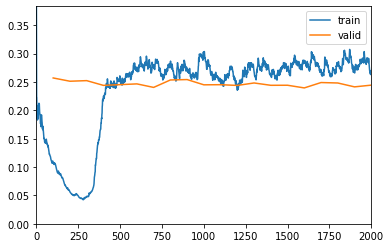

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.937975,0.728184,0.225000,0.775000,0.741429,00:04
1,0.531894,0.341320,0.132500,0.867500,0.804571,00:04
2,0.383303,0.254730,0.105000,0.895000,0.883371,00:04
3,0.314106,0.251124,0.102500,0.897500,0.895886,00:04


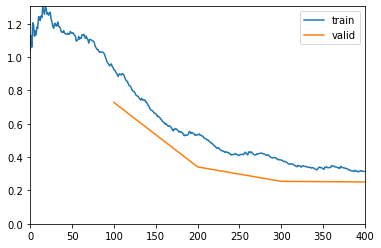

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.106141,0.244853,0.092500,0.907500,0.896286,00:06
1,0.057631,0.241577,0.095000,0.905000,0.898857,00:06
2,0.037856,0.246927,0.097500,0.902500,0.895086,00:06
3,0.203985,0.250457,0.102500,0.897500,0.896400,00:06
4,0.278473,0.233495,0.092500,0.907500,0.905714,00:06
5,0.305605,0.247118,0.095000,0.905000,0.895086,00:06
6,0.288644,0.243855,0.090000,0.910000,0.894571,00:06
7,0.285272,0.240132,0.097500,0.902500,0.898171,00:06
8,0.258610,0.238201,0.090000,0.910000,0.901543,00:06
9,0.302686,0.246406,0.095000,0.905000,0.895086,00:06


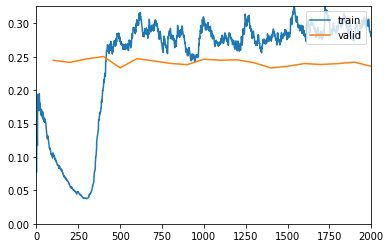

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.086122,0.537160,0.212500,0.787500,0.722689,00:04
1,0.530198,0.291487,0.112500,0.887500,0.824246,00:04


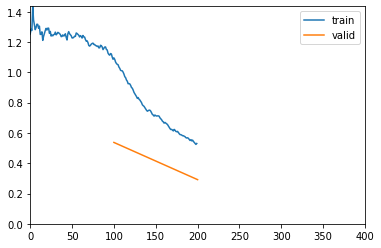

KeyboardInterrupt: 

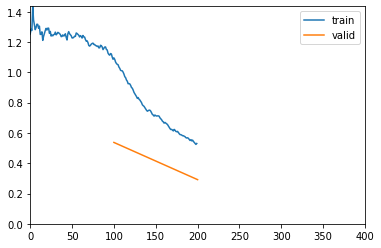

In [129]:
seeds = [1,2,3,4,5,6,7,8,9,10]
epochs = 20

for s in seeds:
    data = reload_dataset(dm,s)    
    random_seed(s,True)
    
    #No color correction
    learn = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph], 
                        pretrained=True)

    
    simple_train(learn,s,epochs)

    
    #Con color correction
    data = reload_dataset(dm,s)
    
    random_seed(s,True)
    
    # Insertamos en train como en valid ds, la correcion de color Max rgb en la primer posicion
    correct_color_max_rgb.order = 0 
    data.train_ds.tfms.insert(0,correct_color_max_rgb());
    data.valid_ds.tfms.insert(0,correct_color_max_rgb());

    random_seed(s,True)

    learn_max_rgb = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph], 
                        pretrained=True)

    simple_train(learn_max_rgb, s,epochs)
    
    write_results(s, learn, learn_max_rgb)
    

# Analyze results

In [ ]:
runs = {}
for i in range(1,11):
    runs[i] = pd.read_csv(f'{results_file_name}_{i}.txt')
    runs[i].plot()

In [ ]:
max_acc_for_each_run_max_rgb = [runs[r].max()[' Max_RGB'] for r in runs]
max_acc_for_each_run_baseline = [runs[r].max()['Without Color Correction'] for r in runs]

In [ ]:
df = pd.DataFrame({
                    'Baseline':max_acc_for_each_run_baseline,
                    'Max RGB': max_acc_for_each_run_max_rgb
                })

In [ ]:
df.describe()

In [122]:
avg_max_rgb_acc = np.mean(max_acc_for_each_run_max_rgb)
std_max_rgb_acc = np.std(max_acc_for_each_run_max_rgb)



avg_baseline_acc = np.mean(max_acc_for_each_run_baseline)
std_baseline_acc = np.std(max_acc_for_each_run_baseline)

In [125]:
avg_max_rgb_acc,std_max_rgb_acc

(0.887499988079071, 0.019472183839107243)

In [124]:
avg_baseline_acc,std_baseline_acc

(0.8933333158493042, 0.009204458736258405)

In [ ]:


times_max_rgb_had_higher_acc = [runs[i].max()['Without Color Correction'] < runs[i].max()[' Max_RGB'] for i in runs]

arl_effectiveness = sum(times_max_rgb_had_higher_acc)/ len(runs)

print(f'MAX RGB improved the Accuracy in {arl_effectiveness*100}% of the cases')